In [1]:
%matplotlib inline

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
from mpl_toolkits.mplot3d import Axes3D

In [160]:
with h5py.File('../build/release/result.h5') as f:
    data = f['dataset'][:]

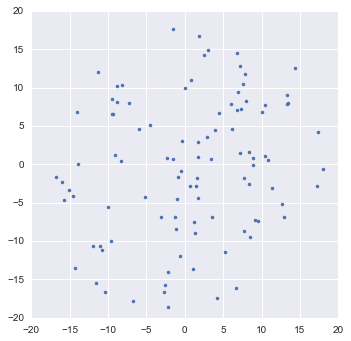

In [161]:
plt.plot(data[0, 0, :], data[0, 1, :], '.')
plt.gca().set_aspect(1)

In [162]:
i = -1

109


IndexError: index 109 is out of bounds for axis 0 with size 101

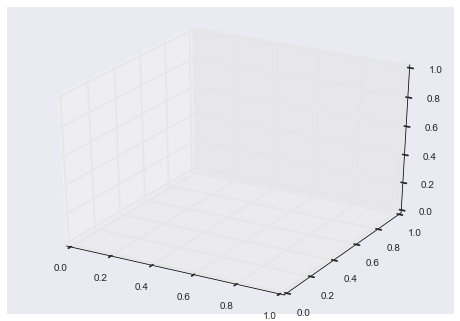

In [173]:
i += 10
print(i)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data[i, 0, :], data[i, 1, :], data[0, 2, :])
ax.set_xlim(-30, 30)
ax.set_ylim(-30, 30)
ax.set_zlim(-30, 30)

In [ ]:
for 